# House Sale Price Prediction
This project focuses around a dataset with housing data from the city of Ames, Iowa, United States from 2006 to 2010. A linear regression model is constructed to predict housing sale prices. To improve model performance, feature engineering is performed, as well as automated feature selection. More details regarding the dataset can be found [here](https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627), as well as [column descriptions](https://s3.amazonaws.com/dq-content/307/data_description.txt).

First we will setup a few helper functions so that our pipeline will be easier to experiment with later. The reasoning behind each function follows.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score


In [2]:
## Helper functions

def transform_features(df):
    # Remove 'object' type features with any missing values
    obj_null_counts = df.select_dtypes(include=['object']).isnull().sum()
    obj_to_drop = obj_null_counts[obj_null_counts > 0].index
    new_df = df.copy().drop(obj_to_drop, axis=1)
    
    # Remove features that have >5% of missing data
    null_cutOff = 0.05
    nRows = df.shape[0]
    nullCounts = new_df.isnull().sum()
    nullPercent = nullCounts / nRows
    cols_to_drop = nullPercent[nullPercent > null_cutOff].index
    new_df = new_df.copy().drop(cols_to_drop, axis=1)

    # Impute mode for features with <=5% of missing data
    cols_to_impute = nullPercent[nullPercent <= null_cutOff].index
    col_modes = new_df.mode()
    to_impute = new_df[cols_to_impute].mode().to_dict(orient='records')[0]
    new_df = new_df.copy().fillna(to_impute)
    
    # Engineered Features
    new_df['years_until_remod'] = new_df['Year Remod/Add'] - new_df['Year Built']
    new_df['years_since_remod'] = new_df['Yr Sold'] - new_df['Year Remod/Add'] 
    new_df['years_since_built'] = new_df['Yr Sold'] - new_df['Year Built']

    id1 = new_df['years_until_remod'].loc[new_df['years_until_remod'] < 0].index
    id2 = new_df['years_since_remod'].loc[new_df['years_since_remod'] < 0].index
    id3 = new_df['years_since_built'].loc[new_df['years_since_built'] < 0].index
    ids = id1.append([id2, id3])
    index_neg_yr = set(ids)
    new_df = new_df.copy().drop(index_neg_yr, axis=0)
    new_df = new_df.copy().drop(['Year Remod/Add', 'Year Built'], axis=1)
    
    # Drop columns which leak data about the sale
    new_df = new_df.copy().drop(['Mo Sold', 'Yr Sold', 'Sale Type', 'Sale Condition'], axis=1)
    
    # Drop useless feature columns for price prediction
    new_df = new_df.copy().drop(['Order', 'PID'], axis=1)

    return new_df

def select_features(df, corr_coef_thresh=0.4, max_unique_thresh=10):
    # Drop numerical features with low correlation to SalePrice
    numeric_df = df.select_dtypes(include=['number'])
    SalePrice_corr = numeric_df.corr()[['SalePrice']].abs()
    features_to_drop = SalePrice_corr[SalePrice_corr['SalePrice']<corr_coef_thresh].index
    new_df = df.copy().drop(features_to_drop, axis=1)
     
    categorical = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                "Misc Feature", "Sale Type", "Sale Condition"]

    # List of categorical columns we still have
    remaining_cat_cols = []
    for col in categorical:
        if col in new_df.columns:
            remaining_cat_cols.append(col)
            
    # Count num of unique values in each categorical column
    unique_counts = new_df[remaining_cat_cols].apply(lambda feature: len(feature.value_counts()))

    # Drop categorical features with more than the set threshold of unique values
    new_df = new_df.copy().drop(unique_counts[unique_counts > max_unique_thresh].index, axis=1)
    
    # Convert all categorical columns to categorical type
    cat_cols = new_df.select_dtypes(include=['object'])
    for col in cat_cols:
        new_df[col] = new_df[col].astype('category')

    # One hot encoding of selected categorical variables
    cat_cols = new_df.select_dtypes(include=['category'])
    one_hot_encoded = pd.get_dummies(cat_cols)
    new_df = pd.concat([new_df, one_hot_encoded], axis=1)
    new_df = new_df.copy().drop(cat_cols.columns, axis=1)

    return new_df

def train_and_test(df, k=0):
    lr = LinearRegression()
    features = df.select_dtypes(include=['number']).drop('SalePrice', axis=1).columns
    
    # k=0 - Holdout Validation
    if k==0:
        # Split data
        train = df.loc[:1460]
        test = df.loc[1460:]

        # Train model
        X_train = train[features]
        y_train = train['SalePrice']
        lr.fit(X_train, y_train)

        # Test Model on test split
        X_test = test[features]
        y_test = test['SalePrice']
        predictions_test = lr.predict(X_test)
        rmse = mean_squared_error(y_test, predictions_test) ** (1/2)
        return rmse
    
    # k=1 - Simple cross validation with 2 folds
    elif k==1:
        # Shuffle rows
        shuffled_df = df.sample(frac=1)
        # Split data into 2 folds
        fold_one = df.loc[:1460]
        fold_two = df.loc[1460:]
        
        # Train on fold_one, test on fold_two
        lr.fit(fold_one[features], fold_one['SalePrice'])
        predictions_test_f2 = lr.predict(fold_two[features])
        rmse_f2 = mean_squared_error(fold_two['SalePrice'], predictions_test_f2) ** (1/2)
        
        # Train on fold_two, test on fold_one
        lr.fit(fold_two[features], fold_two['SalePrice'])
        predictions_test_f1 = lr.predict(fold_one[features])
        rmse_f1 = mean_squared_error(fold_one['SalePrice'], predictions_test_f1) ** (1/2)
        
        avg_rmse = (rmse_f1 + rmse_f2) / 2
        return avg_rmse
    
    # k>1 - KFold cross validation with k folds
    elif k>1:
        kf = KFold(n_splits=k, shuffle=True)
        val_scores = cross_val_score(lr, df[features], df['SalePrice'],
                                     scoring='neg_mean_squared_error',
                                     cv=kf)
        avg_rmse = np.mean(np.sqrt(-1 * val_scores))
        return avg_rmse
        
    


In [3]:
houseData = pd.read_csv('AmesHousing.tsv', delimiter='\t')
pd.options.display.max_columns = 200

houseData.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


## Feature Engineering
Next, we will explore the data to decide how to process the features. This will involve dealing with missing data, selecting which features to keep, and creating new features.

Any feature transformations discussed are encoded in the helper function: `transform_features()`. 

In [4]:
print(houseData.shape)
# Missing Value Distribution
houseData.isnull().sum()

(2930, 82)


Order               0
PID                 0
MS SubClass         0
MS Zoning           0
Lot Frontage      490
                 ... 
Mo Sold             0
Yr Sold             0
Sale Type           0
Sale Condition      0
SalePrice           0
Length: 82, dtype: int64

Since some columns contain a large proportion of missing values, columns with more than 5% missing data will be dropped.

The remaining columns with less than 5% missing data will be imputed with the mode of their respective column. The most common value is selected since it is more resistant to noisy data compared to the mean.

Additionally, we should drop columns which leak data regarding the final sale. As such we will drop the features: `Mo Sold`,  `Yr Sold`,  `Sale Type`, and  `Sale Condition`.

Also, we will drop features that will not help the price prediction model, such as `PID` and `Order`.

In [5]:
## Ensure none of the text data is actually numerical
houseData.select_dtypes(include=['object']).head(10)

,MS Zoning,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Heating,Heating QC,Central Air,Electrical,Kitchen Qual,Functional,Fireplace Qu,Garage Type,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Pool QC,Fence,Misc Feature,Sale Type,Sale Condition
0,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,BrkFace,Plywood,Stone,TA,TA,CBlock,TA,Gd,Gd,BLQ,Unf,GasA,Fa,Y,SBrkr,TA,Typ,Gd,Attchd,Fin,TA,TA,P,NaN,NaN,NaN,WD,Normal
1,RH,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,CBlock,TA,TA,No,Rec,LwQ,GasA,TA,Y,SBrkr,TA,Typ,NaN,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,TA,TA,CBlock,TA,TA,No,ALQ,Unf,GasA,TA,Y,SBrkr,Gd,Typ,NaN,Attchd,Unf,TA,TA,Y,NaN,NaN,Gar2,WD,Normal
3,RL,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,BrkFace,BrkFace,None,Gd,TA,CBlock,TA,TA,No,ALQ,Unf,GasA,Ex,Y,SBrkr,Ex,Typ,TA,Attchd,Fin,TA,TA,Y,NaN,NaN,NaN,WD,Normal
4,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Gd,Y,SBrkr,TA,Typ,TA,Attchd,Fin,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
5,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,TA,TA,PConc,TA,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,Fin,TA,TA,Y,NaN,NaN,NaN,WD,Normal
6,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,Gable,CompShg,CemntBd,CmentBd,None,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,Fin,TA,TA,Y,NaN,NaN,NaN,WD,Normal
7,RL,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,Gable,CompShg,HdBoard,HdBoard,None,Gd,TA,PConc,Gd,TA,No,ALQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
8,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,Gable,CompShg,CemntBd,CmentBd,None,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
9,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,TA,Attchd,Fin,TA,TA,Y,NaN,NaN,NaN,WD,Normal


Inspecting the text data provided, it seems that there are no accidental 'object' types which should be numerical.

In [6]:
houseData.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)

Pool QC           2917
Misc Feature      2824
Alley             2732
Fence             2358
Fireplace Qu      1422
Garage Cond        159
Garage Qual        159
Garage Finish      159
Garage Type        157
Bsmt Exposure       83
BsmtFin Type 2      81
BsmtFin Type 1      80
Bsmt Qual           80
Bsmt Cond           80
Mas Vnr Type        23
Electrical           1
Condition 2          0
Condition 1          0
Neighborhood         0
Land Slope           0
Bldg Type            0
Land Contour         0
Lot Config           0
Utilities            0
Roof Style           0
Lot Shape            0
Street               0
House Style          0
Sale Condition       0
Roof Matl            0
Exterior 1st         0
Exterior 2nd         0
Exter Qual           0
Exter Cond           0
Foundation           0
Sale Type            0
Heating              0
Heating QC           0
Central Air          0
Kitchen Qual         0
Functional           0
Paved Drive          0
MS Zoning            0
dtype: int6

For the time being, any 'object' type columns with any missing values will be removed since it seems that most of the information is already captured by redundant features (Condition, Quality, etc.), or have a significant number of missing values.

### Adding New Features
In examining the existing features, we can construct new features to improve the performance of our model. Year information provided doesn't provide much information on its own. It would be more valuable to find out the time since an event occurred. As such, we will add the following features:
 - The number of years it took to remodel the property since it was built.
 - The number of years since a remodel took place, relative to the year the house was sold.
 - The number of years a house was built for, relative to the year the house was sold.

In [7]:
years_until_remod = houseData['Year Remod/Add'] - houseData['Year Built']
years_until_remod[years_until_remod < 0]

850   -1
dtype: int64

In [8]:
years_since_remod = houseData['Yr Sold'] - houseData['Year Remod/Add'] 
years_since_remod[years_since_remod < 0]

1702   -1
2180   -2
2181   -1
dtype: int64

In [9]:
years_since_built = houseData['Yr Sold'] - houseData['Year Built'] 
years_since_built[years_since_built < 0]

2180   -1
dtype: int64

After engineering these new features, some values are negative, so we should remove the rows corresponding to these values since they don't make sense.

Also, since the new features were based on the originally provided features, we can drop the original features used for feature engineering as it is redundant information.

In [10]:
# Apply the feature transformations to the dataframe
transformed = transform_features(houseData)
transformed.head()

,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Cars,Garage Area,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,SalePrice,years_until_remod,years_since_remod,years_since_built
0,20,RL,31770,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,Hip,CompShg,BrkFace,Plywood,112.0,TA,TA,CBlock,639.0,0.0,441.0,1080.0,GasA,Fa,Y,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,2.0,528.0,P,210,62,0,0,0,0,0,215000,0,50,50
1,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,Gable,CompShg,VinylSd,VinylSd,0.0,TA,TA,CBlock,468.0,144.0,270.0,882.0,GasA,TA,Y,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,1.0,730.0,Y,140,0,0,0,120,0,0,105000,0,49,49
2,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,Hip,CompShg,Wd Sdng,Wd Sdng,108.0,TA,TA,CBlock,923.0,0.0,406.0,1329.0,GasA,TA,Y,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,1.0,312.0,Y,393,36,0,0,0,0,12500,172000,0,52,52
3,20,RL,11160,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,Hip,CompShg,BrkFace,BrkFace,0.0,Gd,TA,CBlock,1065.0,0.0,1045.0,2110.0,GasA,Ex,Y,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,2.0,522.0,Y,0,0,0,0,0,0,0,244000,0,42,42
4,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,Gable,CompShg,VinylSd,VinylSd,0.0,TA,TA,PConc,791.0,0.0,137.0,928.0,GasA,Gd,Y,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,2.0,482.0,Y,212,34,0,0,0,0,0,189900,1,12,13


In [11]:
# Verify there are no missing values
transformed.isnull().sum().sum()

0

## Feature Selection
Next, to determine which features are the most informative, we will generate a correlation matrix for the numerical features in our training set.

In [12]:
numeric_df = transformed.select_dtypes(include=['number'])
numeric_df.head()

,MS SubClass,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,SalePrice,years_until_remod,years_since_remod,years_since_built
0,20,31770,6,5,112.0,639.0,0.0,441.0,1080.0,1656,0,0,1656,1.0,0.0,1,0,3,1,7,2,2.0,528.0,210,62,0,0,0,0,0,215000,0,50,50
1,20,11622,5,6,0.0,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1.0,730.0,140,0,0,0,120,0,0,105000,0,49,49
2,20,14267,6,6,108.0,923.0,0.0,406.0,1329.0,1329,0,0,1329,0.0,0.0,1,1,3,1,6,0,1.0,312.0,393,36,0,0,0,0,12500,172000,0,52,52
3,20,11160,7,5,0.0,1065.0,0.0,1045.0,2110.0,2110,0,0,2110,1.0,0.0,2,1,3,1,8,2,2.0,522.0,0,0,0,0,0,0,0,244000,0,42,42
4,60,13830,5,5,0.0,791.0,0.0,137.0,928.0,928,701,0,1629,0.0,0.0,2,1,3,1,6,1,2.0,482.0,212,34,0,0,0,0,0,189900,1,12,13


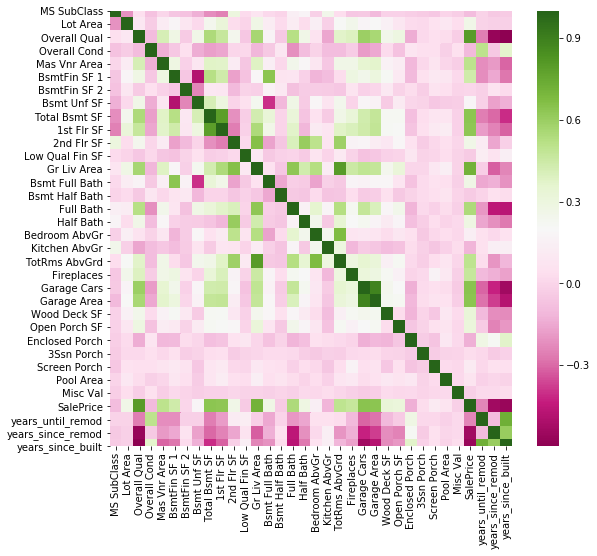

In [13]:
import seaborn as sns
plt.figure(figsize=(9, 8))
plt.tight_layout()

# Generate correlation matrix and corresponding heatmap
corr_mat = numeric_df.corr()
sns.heatmap(corr_mat, cmap="PiYG")
plt.show()

There appears to be some strongly correlated features corresponding to the `SalePrice` column. Let's isolate for this column for a clearer understanding.

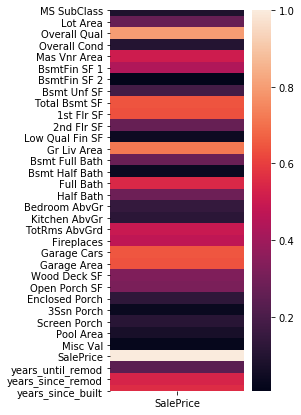

In [14]:
SalePrice_corr = numeric_df.corr()[['SalePrice']].abs()
plt.figure(figsize=(3, 7))
sns.heatmap(SalePrice_corr)
plt.show()

In [15]:
SalePrice_corr.sort_values(by='SalePrice', ascending=False)

,SalePrice
SalePrice,1.000000
Overall Qual,0.801212
Gr Liv Area,0.717617
Garage Cars,0.648351
Total Bsmt SF,0.644023
Garage Area,0.641414
1st Flr SF,0.635183
years_since_built,0.558984
Full Bath,0.546108
years_since_remod,0.534972


Next we will isolate for features which correlate the most with `SalePrice` by establishing a cutoff correlation of >0.4.

In [16]:
corr_cutoff = 0.4
SalePrice_corr[SalePrice_corr['SalePrice']>corr_cutoff].sort_values(by='SalePrice', ascending=False)

,SalePrice
SalePrice,1.000000
Overall Qual,0.801212
Gr Liv Area,0.717617
Garage Cars,0.648351
Total Bsmt SF,0.644023
Garage Area,0.641414
1st Flr SF,0.635183
years_since_built,0.558984
Full Bath,0.546108
years_since_remod,0.534972


In [17]:
# Drop features with a correlation value less than corr_cutoff
features_to_drop = SalePrice_corr[SalePrice_corr['SalePrice']<corr_cutoff].index

transformed.drop(features_to_drop, axis=1, inplace=True)
transformed.head()

,MS Zoning,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,BsmtFin SF 1,Total Bsmt SF,Heating,Heating QC,Central Air,1st Flr SF,Gr Liv Area,Full Bath,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Cars,Garage Area,Paved Drive,SalePrice,years_since_remod,years_since_built
0,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,Hip,CompShg,BrkFace,Plywood,112.0,TA,TA,CBlock,639.0,1080.0,GasA,Fa,Y,1656,1656,1,TA,7,Typ,2,2.0,528.0,P,215000,50,50
1,RH,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,Gable,CompShg,VinylSd,VinylSd,0.0,TA,TA,CBlock,468.0,882.0,GasA,TA,Y,896,896,1,TA,5,Typ,0,1.0,730.0,Y,105000,49,49
2,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,Hip,CompShg,Wd Sdng,Wd Sdng,108.0,TA,TA,CBlock,923.0,1329.0,GasA,TA,Y,1329,1329,1,Gd,6,Typ,0,1.0,312.0,Y,172000,52,52
3,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,Hip,CompShg,BrkFace,BrkFace,0.0,Gd,TA,CBlock,1065.0,2110.0,GasA,Ex,Y,2110,2110,2,Ex,8,Typ,2,2.0,522.0,Y,244000,42,42
4,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,Gable,CompShg,VinylSd,VinylSd,0.0,TA,TA,PConc,791.0,928.0,GasA,Gd,Y,928,1629,2,TA,6,Typ,1,2.0,482.0,Y,189900,12,13


We will also convert any nominal variables to categorical type. The column descriptions are provided in the documentation linked above.

In [18]:
categorical = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                "Misc Feature", "Sale Type", "Sale Condition"]


# List of categorical columns we still have
remaining_cat_cols = []
for col in categorical:
    if col in transformed.columns:
        remaining_cat_cols.append(col)
        
print(remaining_cat_cols)

['MS Zoning', 'Street', 'Land Contour', 'Lot Config', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Foundation', 'Heating', 'Central Air']


Ultimately we will be one-hot-encoding the categorical variables. In the case that a categorical column has too many unique values, it would not help the machine learning algorithm make predictions and would only contribute noise. To mitigate this, we can set a threshold for the maximum number of unique values a feature column can have.

In [19]:
# Count num of unique values in each categorical column
unique_counts = transformed[remaining_cat_cols].apply(lambda feature: len(feature.value_counts()))

# Drop categorical features with more than the set threshold of unique values
max_unique_thresh = 10
transformed.drop(unique_counts[unique_counts > max_unique_thresh].index, axis=1, inplace=True)

Next, we will one-hot-encode the categorical features remaining in the dataframe, so they can be used at numerical inputs to our prediction algorithm.

In [20]:
# Convert all categorical columns to categorical type
cat_cols = transformed.select_dtypes(include=['object'])
for col in cat_cols:
    transformed[col] = transformed[col].astype('category')
    
# One hot encoding of categorical variables
cat_cols = transformed.select_dtypes(include=['category'])
one_hot_encoded = pd.get_dummies(cat_cols)
transformed = pd.concat([transformed, one_hot_encoded], axis=1)
transformed.drop(cat_cols.columns, axis=1, inplace=True)

In [21]:
transformed.head()

,Overall Qual,Mas Vnr Area,BsmtFin SF 1,Total Bsmt SF,1st Flr SF,Gr Liv Area,Full Bath,TotRms AbvGrd,Fireplaces,Garage Cars,Garage Area,SalePrice,years_since_remod,years_since_built,MS Zoning_A (agr),MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Street_Grvl,Street_Pave,Lot Shape_IR1,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg,Land Contour_Bnk,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Utilities_AllPub,Utilities_NoSeWa,Utilities_NoSewr,Lot Config_Corner,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Land Slope_Gtl,Land Slope_Mod,Land Slope_Sev,Condition 1_Artery,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Artery,Condition 2_Feedr,Condition 2_Norm,Condition 2_PosA,Condition 2_PosN,Condition 2_RRAe,Condition 2_RRAn,Condition 2_RRNn,Bldg Type_1Fam,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,House Style_1.5Fin,House Style_1.5Unf,House Style_1Story,House Style_2.5Fin,House Style_2.5Unf,House Style_2Story,House Style_SFoyer,House Style_SLvl,Roof Style_Flat,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,Roof Style_Shed,Roof Matl_ClyTile,Roof Matl_CompShg,Roof Matl_Membran,Roof Matl_Metal,Roof Matl_Roll,Roof Matl_Tar&Grv,Roof Matl_WdShake,Roof Matl_WdShngl,Exter Qual_Ex,Exter Qual_Fa,Exter Qual_Gd,Exter Qual_TA,Exter Cond_Ex,Exter Cond_Fa,Exter Cond_Gd,Exter Cond_Po,Exter Cond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Heating QC_Ex,Heating QC_Fa,Heating QC_Gd,Heating QC_Po,Heating QC_TA,Central Air_N,Central Air_Y,Kitchen Qual_Ex,Kitchen Qual_Fa,Kitchen Qual_Gd,Kitchen Qual_Po,Kitchen Qual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Sev,Functional_Typ,Paved Drive_N,Paved Drive_P,Paved Drive_Y
0,6,112.0,639.0,1080.0,1656,1656,1,7,2,2.0,528.0,215000,50,50,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
1,5,0.0,468.0,882.0,896,896,1,5,0,1.0,730.0,105000,49,49,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
2,6,108.0,923.0,1329.0,1329,1329,1,6,0,1.0,312.0,172000,52,52,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
3,7,0.0,1065.0,2110.0,2110,2110,2,8,2,2.0,522.0,244000,42,42,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
4,5,0.0,791.0,928.0,928,1629,2,6,1,2.0,482.0,189900,12,13,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1


With this framework we now have a proper set of features in numeric form that we can use in our prediction model. We can update our helper function `select_features()` accordingly to incorporate these feature selection transformations.

## Testing the Model
With the helper functions created, the performance of the model can easily be evaluated.

In [22]:
# Holdout Validation
transformed = transform_features(houseData)
selected = select_features(transformed, corr_coef_thresh=0.4, max_unique_thresh=10)
rmse = train_and_test(selected, k=0)
print('Holdout Validation RMSE:', rmse)

Holdout Validation RMSE: 33375.20233658815


In [23]:
# 2-Fold Validation
transformed = transform_features(houseData)
selected = select_features(transformed, corr_coef_thresh=0.4, max_unique_thresh=10)
rmse = train_and_test(selected, k=1)
print('2-Fold Cross Validation RMSE:', rmse)

2-Fold Cross Validation RMSE: 30262.474839453876


In [24]:
# 5-Fold Validation
transformed = transform_features(houseData)
selected = select_features(transformed, corr_coef_thresh=0.4, max_unique_thresh=10)
rmse = train_and_test(selected, k=5)
print('5-Fold Cross Validation RMSE:', rmse)

5-Fold Cross Validation RMSE: 29125.333962140983


## Automated Feature Selection
Finally, we can try finding an optimal set of features to keep which will yield the lowest RMSE by searching through the parameters in `select_features()`:
- `corr_coef_thresh` - minimum pearson correlation to the target variable to be included as a feature
- `max_unique_thresh` - maximum number of unique values a categorical feature can have

In [25]:
# Parameter grid to search through
corr_coef_threshs = [0.3, 0.5, 0.6, 0.7]
max_unique_threshs = [6, 8, 10]

fiveFold_rmses = {}

for corr_param in corr_coef_threshs:
    for unique_param in max_unique_threshs:
        transformed = transform_features(houseData)
        selected = select_features(transformed,
                                   corr_coef_thresh=corr_param,
                                   max_unique_thresh=unique_param)
        rmse = train_and_test(selected, k=5)
        print('corr_coef_thresh: {:.1f}, max_unique_thresh: {:d} \n 5-Fold Cross Validation RMSE: {:.2f} \n'.format(corr_param, unique_param, rmse))
        key = (corr_param, unique_param)
        fiveFold_rmses[key] = rmse

corr_coef_thresh: 0.3, max_unique_thresh: 6 
 5-Fold Cross Validation RMSE: 29351.01 

corr_coef_thresh: 0.3, max_unique_thresh: 8 
 5-Fold Cross Validation RMSE: 29145.68 

corr_coef_thresh: 0.3, max_unique_thresh: 10 
 5-Fold Cross Validation RMSE: 28700.12 

corr_coef_thresh: 0.5, max_unique_thresh: 6 
 5-Fold Cross Validation RMSE: 30586.24 

corr_coef_thresh: 0.5, max_unique_thresh: 8 
 5-Fold Cross Validation RMSE: 30079.59 

corr_coef_thresh: 0.5, max_unique_thresh: 10 
 5-Fold Cross Validation RMSE: 29858.97 

corr_coef_thresh: 0.6, max_unique_thresh: 6 
 5-Fold Cross Validation RMSE: 31299.65 

corr_coef_thresh: 0.6, max_unique_thresh: 8 
 5-Fold Cross Validation RMSE: 30612.49 

corr_coef_thresh: 0.6, max_unique_thresh: 10 
 5-Fold Cross Validation RMSE: 30601.22 

corr_coef_thresh: 0.7, max_unique_thresh: 6 
 5-Fold Cross Validation RMSE: 33312.65 

corr_coef_thresh: 0.7, max_unique_thresh: 8 
 5-Fold Cross Validation RMSE: 31571.76 

corr_coef_thresh: 0.7, max_unique_thresh

In [26]:
# Get feature selection parameters with lowest RMSE
opt_key = min(fiveFold_rmses, key=fiveFold_rmses.get)
lowest_rmse = fiveFold_rmses[opt_key]

print('Best Found corr_coef_thresh:', opt_key[0])
print('Best Found max_unique_thresh:', opt_key[1])
print('Lowest RMSE:', round(lowest_rmse, 2))

Best Found corr_coef_thresh: 0.3
Best Found max_unique_thresh: 10
Lowest RMSE: 28700.12


After performing a grid search on the feature selection parameters we've implemented, we find that `corr_coef_thresh=0.3`, and `max_unique_thresh=10`, yield the linear regression model with the lowest RMSE on a 5-Fold cross validation.